In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import os
import glob

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

import copy

In [8]:
simulation_start_date = date(2023, 2, 1)
results_root_dir='/Users/kiran/agentfil/exp'

experiment_dirs = [
    "maxrbponboard-75.00_nagents-5_type-farsighted_optimism-2_maxpow-0.20_geometricdist",
    "maxrbponboard-75.00_nagents-5_type-farsighted_optimism-2_maxpow-0.40_geometricdist",
]

examine_idx = 1
examine_dir = experiment_dirs[examine_idx]

In [9]:
# agent plotting helper functions
def plot_agent(keys, experiment_dir,
               x_post_process=None, 
               y_post_process=None,
               agent_ids_to_plot=None,
               df_name='agent_info_df',
               x_key='date', label_prepend='', label_postpend='', plot_kwargs_list=None):
    if x_post_process is None:
        x_post_fn = lambda x: x
    else:
        x_post_fn = x_post_process
    if y_post_process is None:
        y_post_fn = lambda x: x
    else:
        y_post_fn = y_post_process
    
    # read all of the agent infos into memory
    agent2agentinfo = {}
    agent2accountinginfo = {}
    flist = glob.glob(os.path.join(results_root_dir, experiment_dir, '*.csv'))
    for fp in flist:
        fname = os.path.basename(fp)
        if 'filecoin_df' in fname:
            pass
        else:
            # parse the agent # from teh filename
            agent_num = int(fname.split('_')[1])
            
            if 'agent_info' in fname:
                agent2agentinfo[agent_num] = pd.read_csv(fp)
            elif 'accounting' in fname:
                agent2accountinginfo[agent_num] = pd.read_csv(fp)
    num_total_agents = len(agent2agentinfo)

    for ii in range(num_total_agents):
        if agent_ids_to_plot is None or ii in agent_ids_to_plot:  # assumes ii is same as agent-id
            if 'agent_info' in df_name:
                agent_df = agent2agentinfo[ii]
            elif 'accounting' in df_name:
                agent_df = agent2accountinginfo[ii]
            else:
                print(df_name)
                raise ValueError("")
            
            l = label_prepend + '-Agent%d' % (ii,) + '-' + label_postpend
            plot_kwargs = plot_kwargs_list[ii] if plot_kwargs_list is not None else {}
            if len(keys)==1:
                k = keys[0]
                x = x_post_fn(agent_df[x_key])
                y = y_post_fn(agent_df[k])
                plt.plot(x, y, label=l, **plot_kwargs)
            else:
                # get all keys and call the combine function
                key_data = {}
                for k in keys:
                    key_data[k] = agent_df[k]
                x = x_post_fn(agent_df[x_key])
                y = y_post_fn(key_data)
                plt.plot(x, y, label=l, **plot_kwargs)
    plt.xticks(rotation=60)

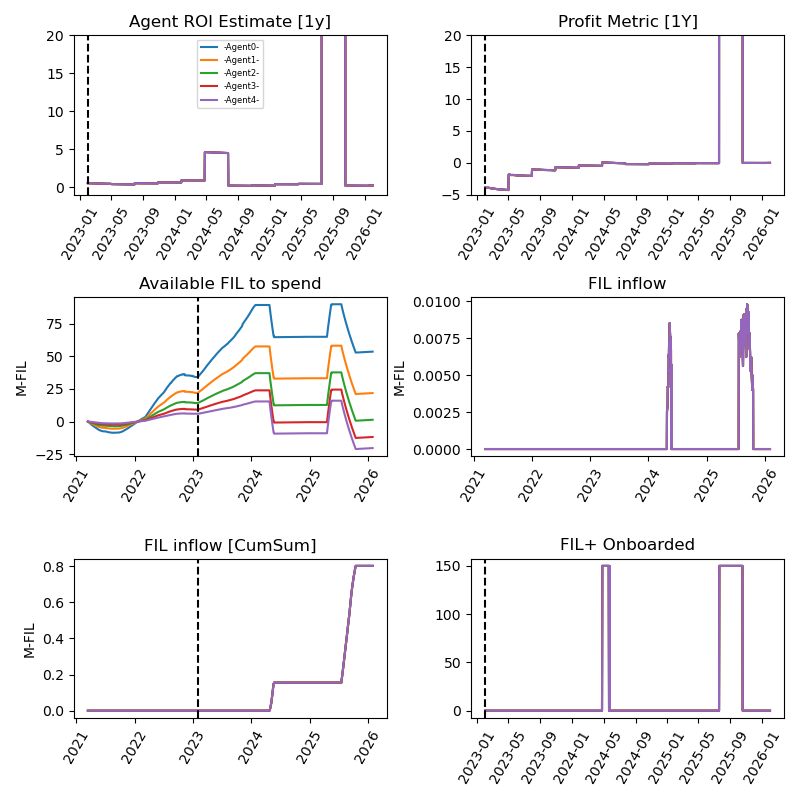

In [10]:
#plt_kwargs = [{'linewidth': 0.8}] * num_agents
def x_post_fn(x_ser_in):
    x_ser_in = pd.to_datetime(x_ser_in)
    return x_ser_in

plt.figure(figsize=(8,8))

plt.subplot(3,2,1)
plot_agent(['roi_estimate_360'], examine_dir, x_post_process=x_post_fn)
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.title('Agent ROI Estimate [1y]')
plt.legend(fontsize=6)
plt.ylim(-1,20)

plt.subplot(3,2,2)
plot_agent(['profit_metric_360'], examine_dir, x_post_process=x_post_fn)
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.title('Profit Metric [1Y]')
plt.ylim(-5,20)

plt.subplot(3,2,3)
keys = ['reward_FIL', 
        'onboard_pledge_FIL', 
        'renew_pledge_FIL', 
        'onboard_scheduled_pledge_release_FIL', 
        'renew_scheduled_pledge_release_FIL',
        'capital_inflow_FIL']
def compute_available_fil_to_spend(key_data):
    available_FIL_to_spend = key_data['reward_FIL'].cumsum() \
                           - key_data['onboard_pledge_FIL'].cumsum() \
                           - key_data['renew_pledge_FIL'].cumsum() \
                           + key_data['onboard_scheduled_pledge_release_FIL'].cumsum() \
                           + key_data['renew_scheduled_pledge_release_FIL'].cumsum() \
                           + key_data['capital_inflow_FIL'].cumsum()
    return available_FIL_to_spend/1_000_000
plot_agent(keys, examine_dir, 
           x_post_process=x_post_fn, y_post_process=compute_available_fil_to_spend, 
           df_name='accounting_df')
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.ylabel('M-FIL')
plt.title('Available FIL to spend')

plt.subplot(3,2,4)
post_process = lambda x: x/1_000_000
plot_agent(['capital_inflow_FIL'], examine_dir, 
           x_post_process=x_post_fn, y_post_process=post_process, 
           df_name='accounting_df')
plt.title('FIL inflow')
plt.ylabel('M-FIL')

plt.subplot(3,2,5)
post_process = lambda x: x.cumsum()/1_000_000
plot_agent(['capital_inflow_FIL'], examine_dir, 
           x_post_process=x_post_fn, y_post_process=post_process, df_name='accounting_df')
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.title('FIL inflow [CumSum]')
plt.ylabel('M-FIL')

plt.subplot(3,2,6)
plot_agent(['deal_onboarded'], examine_dir, 
           x_post_process=x_post_fn)
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.title('FIL+ Onboarded')


plt.tight_layout()